In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [12]:
# 한글 폰트 설정
import matplotlib.font_manager as fm
plt.rcParams['font.family'] = 'AppleGothic'


In [13]:
# 파일 읽기
olym_df = pd.read_csv("올림픽대로_통행속도_기상.csv", encoding='cp949')

# 결측치 확인
print('올림픽대로 결측치 수 : ',olym_df['속도'].isna().sum())

/var/folders/0t/0jprd7f95qsb1p_xmw35n4l80000gn/T/ipykernel_40678/3343547820.py:3: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  gaepo_df = pd.read_csv("개포로_통행속도_기상.csv", encoding='cp949')


올림픽대로 결측치 수 :  1279
개포로 결측치 수 :  825
논현로 결측치 수 :  1047
도곡로 결측치 수 :  660


In [7]:
olym_df.drop(columns = ['일자', '요일', '도로명', '시점명', '종점명', '방향', '기능유형구분', '도심/외곽구분', '시간','지점', '지점명', 'dateName', 'seq', 'dateKind'], inplace = True)

In [8]:
def fill_missing_values(df):
    # 일시 컬럼을 datetime 형식으로 변환
    df['일시'] = pd.to_datetime(df['일시'])
    
    # 시간 추출
    df['hour'] = df['일시'].dt.hour
    
    # 각 결측치에 대해
    null_indices = df[df['속도'].isnull()].index
    
    for idx in null_indices:
        current_row = df.loc[idx]
        
        # 현재 결측치의 조건과 동일한 데이터 필터링
        same_conditions = (
            (df['링크아이디'] == current_row['링크아이디']) & 
            (df['hour'] == current_row['hour']) & 
            (df['isHoliday'] == current_row['isHoliday']) &
            (df['속도'].notnull())  # 결측치가 아닌 데이터만
        )
        
        # 조건에 맞는 평균 속도 계산
        mean_speed = df[same_conditions]['속도'].mean()
        
        # 만약 조건에 맞는 데이터가 없다면 (mean_speed가 NaN이라면)
        # 휴일 조건을 제외하고 다시 계산
        if pd.isna(mean_speed):
            same_conditions = (
                (df['링크아이디'] == current_row['링크아이디']) & 
                (df['hour'] == current_row['hour']) &
                (df['속도'].notnull())
            )
            mean_speed = df[same_conditions]['속도'].mean()
        
        # 여전히 평균을 구할 수 없다면 전체 링크아이디의 해당 시간대 평균 사용
        if pd.isna(mean_speed):
            same_conditions = (
                (df['hour'] == current_row['hour']) &
                (df['속도'].notnull())
            )
            mean_speed = df[same_conditions]['속도'].mean()
        
        # 결측치 채우기
        df.loc[idx, '속도'] = mean_speed
        
    return df

# 사용 예시:
olym_df = fill_missing_values(olym_df.copy())

print('올림픽대로 결측치 수 : ',olym_df['속도'].isna().sum())

올림픽대로 결측치 수 :  0
개포로 결측치 수 :  0
논현로 결측치 수 :  0
도곡로 결측치 수 :  0


### 이상치 제거

올림픽대로 이상치 제거 전: 279648 후: 275744
개포로 이상치 제거 전: 525960 후: 522338
논현로 이상치 제거 전: 666216 후: 610622
도곡로 이상치 제거 전: 420768 후: 397549


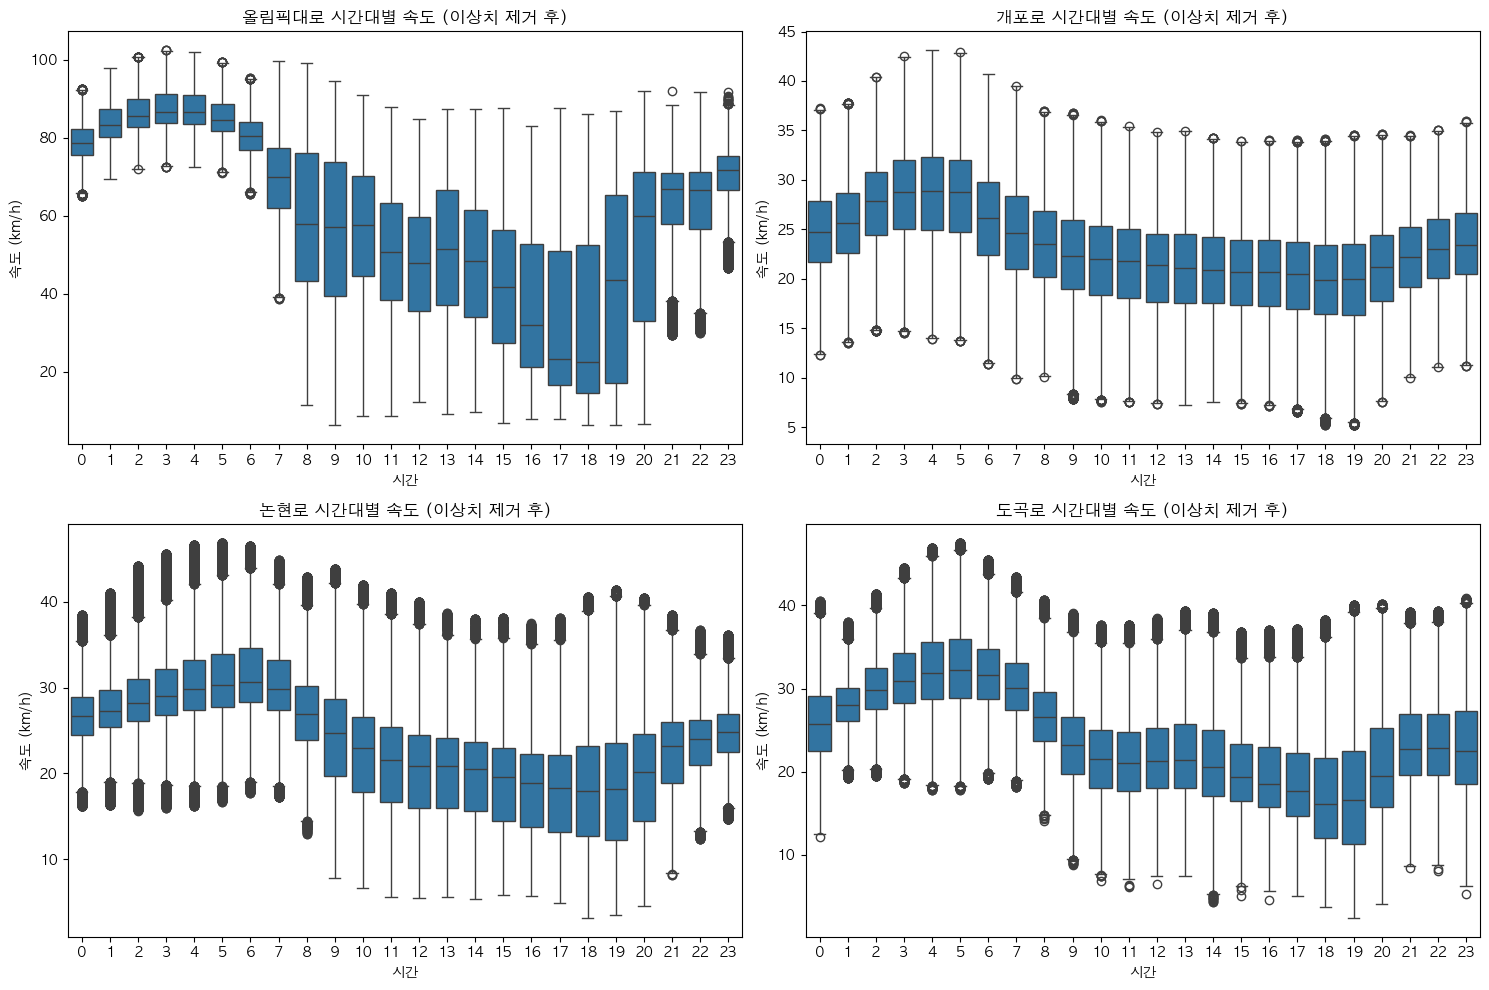


[올림픽대로 시간대별 속도 통계값 (이상치 제거 후)]
        count       mean        std    min    25%    50%    75%     max
hour                                                                   
0     11222.0  79.032661   5.256206  65.00  75.67  78.67  82.33   92.58
1     11475.0  83.998361   5.343272  69.50  80.25  83.17  87.42   98.00
2     11500.0  86.481843   5.357455  71.92  82.75  85.58  89.92  100.83
3     11505.0  87.576734   5.443270  72.50  83.83  86.75  91.25  102.50
4     11491.0  87.384050   5.370425  72.50  83.58  86.58  91.00  102.08
5     11471.0  85.361972   5.235745  71.00  81.75  84.67  88.75   99.50
6     11422.0  80.555432   5.649746  65.67  76.92  80.50  84.17   95.25
7     11567.0  69.435558  10.458777  38.75  62.00  70.08  77.33   99.83
8     11652.0  58.393406  19.056070  11.50  43.33  58.00  76.17   99.25
9     11652.0  56.272287  19.002985   6.25  39.50  57.17  73.92   94.50
10    11652.0  56.158333  16.384653   8.58  44.50  57.67  70.17   91.00
11    11652.0  50.896877  15.821

In [9]:
# 각 도로별 이상치 제거 기준 설정 및 제거
def remove_outliers(df):
    # 시간대별로 그룹화하여 이상치 제거
    df_clean = pd.DataFrame()
    
    for hour in df['hour'].unique():
        # 해당 시간대 데이터 추출
        hour_data = df[df['hour'] == hour].copy()
        
        # 해당 시간대의 IQR 계산
        Q1 = hour_data['속도'].quantile(0.25)
        Q3 = hour_data['속도'].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # 이상치 제거
        hour_data_clean = hour_data[(hour_data['속도'] >= lower_bound) & 
                                  (hour_data['속도'] <= upper_bound)]
        
        # 정제된 데이터 추가
        df_clean = pd.concat([df_clean, hour_data_clean])
    
    return df_clean

# 각 도로별 이상치 제거
olym_df_clean = remove_outliers(olym_df.copy())


# 이상치 제거 전후 데이터 수 비교
print('올림픽대로 이상치 제거 전:', len(olym_df), '후:', len(olym_df_clean))


# 이상치 제거 후 박스플롯 시각화
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 올림픽대로 시간대별 이상치
sns.boxplot(data=olym_df_clean, x='hour', y='속도', ax=axes[0,0])
axes[0,0].set_title('올림픽대로 시간대별 속도 (이상치 제거 후)', fontsize=12)
axes[0,0].set_xlabel('시간')
axes[0,0].set_ylabel('속도 (km/h)')

plt.tight_layout()
plt.show()

# 이상치 제거 후 통계값 출력
print("\n[올림픽대로 시간대별 속도 통계값 (이상치 제거 후)]")
print(olym_df_clean.groupby('hour')['속도'].describe())


### 모델 돌리기

In [ ]:
def train_lstm_model(df, name, target_col, time_steps=24, train_ratio=0.8, epochs=50, batch_size=32):
    """
    LSTM 모델을 학습하고 예측하는 함수
    
    Parameters:
    -----------
    df : DataFrame
        입력 데이터프레임
    target_col : str 
        예측하고자 하는 타겟 컬럼명
    time_steps : int
        시계열 데이터의 시간 스텝 (기본값: 24)
    train_ratio : float
        학습 데이터 비율 (기본값: 0.8)
    epochs : int
        학습 에포크 수 (기본값: 50)
    batch_size : int
        배치 크기 (기본값: 32)
    """
    
    unique_links = df['링크아이디'].unique()
    results = {}
    predictions_df = pd.DataFrame()
    
    for link_id in unique_links:
        print(f"\n링크아이디 {link_id}에 대한 분석")
        
        # 해당 링크의 데이터만 추출
        link_df = df[df['링크아이디'] == link_id]
        
        # 데이터 전처리
        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(link_df[target_col].values.reshape(-1,1))

        # 시계열 데이터셋 생성
        def create_dataset(data, time_steps=1):
            X, y = [], []
            for i in range(len(data) - time_steps):
                X.append(data[i:(i + time_steps), 0])
                y.append(data[i + time_steps, 0])
            return np.array(X), np.array(y)

        # 시계열 데이터 생성
        X, y = create_dataset(scaled_data, time_steps)

        # 학습/테스트 데이터 분할
        train_size = int(len(X) * train_ratio)
        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]

        # 데이터 reshape (LSTM 입력 형태로)
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

        # LSTM 모델 구성
        model = Sequential([
            LSTM(50, activation='relu', input_shape=(time_steps, 1), return_sequences=True),
            LSTM(50, activation='relu'),
            Dense(1)
        ])

        # 모델 컴파일
        model.compile(optimizer='adam', loss='mse')

        # 모델 학습
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                          validation_split=0.1, verbose=0)

        # 예측
        train_predict = model.predict(X_train)
        test_predict = model.predict(X_test)

        # 예측값 역변환
        train_predict = scaler.inverse_transform(train_predict)
        y_train_inv = scaler.inverse_transform([y_train])
        test_predict = scaler.inverse_transform(test_predict)
        y_test_inv = scaler.inverse_transform([y_test])
        
        # 24시간 미래 예측
        last_sequence = scaled_data[-time_steps:]
        future_predictions = []
        
        current_sequence = last_sequence.reshape((1, time_steps, 1))
        for _ in range(24):  # 24시간 예측
            next_pred = model.predict(current_sequence)
            future_predictions.append(next_pred[0,0])
            current_sequence = np.roll(current_sequence, -1)
            current_sequence[0,-1,0] = next_pred[0,0]
            
        future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1,1))
        
        # 예측 결과를 DataFrame에 추가
        temp_df = pd.DataFrame({
            '링크아이디': [link_id] * 24,
            'hour': range(24),
            '예측속도': future_predictions.flatten()
        })
        predictions_df = pd.concat([predictions_df, temp_df])

        # 결과 시각화
        plt.figure(figsize=(15,6))
        plt.plot(y_test_inv.T, label='실제값')
        plt.plot(test_predict, label='예측값')
        plt.title(f'{name} 링크 {link_id} {target_col} 예측 결과')
        plt.xlabel('시간')
        plt.ylabel(target_col)
        plt.legend()
        plt.show()

        # 모델 평가 결과 저장
        results[link_id] = {
            'model': model,
            'scaler': scaler,
            'metrics': {
                'Train RMSE': np.sqrt(mean_squared_error(y_train_inv.T, train_predict)),
                'Test RMSE': np.sqrt(mean_squared_error(y_test_inv.T, test_predict)),
                'Train MAE': mean_absolute_error(y_train_inv.T, train_predict),
                'Test MAE': mean_absolute_error(y_test_inv.T, test_predict),
                'Train R2': r2_score(y_train_inv.T, train_predict),
                'Test R2': r2_score(y_test_inv.T, test_predict),
                'Train Adjusted R2': 1 - (1-r2_score(y_train_inv.T, train_predict))*(len(y_train_inv.T)-1)/(len(y_train_inv.T)-X_train.shape[2]-1),
                'Test Adjusted R2': 1 - (1-r2_score(y_test_inv.T, test_predict))*(len(y_test_inv.T)-1)/(len(y_test_inv.T)-X_test.shape[2]-1)
            }
        }
        
        # 평가 결과 출력
        print(f'{name}의 링크 {link_id} 평가 결과:')
        for metric, value in results[link_id]['metrics'].items():
            print(f'{metric}: {value}')
        print('-' * 50)
    
    # 예측 결과를 CSV 파일로 저장
    predictions_df.to_csv(f'{name}_이상치제거_{target_col}_predictions.csv', index=False)
    return results, predictions_df

### 모델 결과

In [ ]:
results_gaepo = train_lstm_model(olym_df_clean,'이상치 제거한 올림픽대로df', target_col='속도')